## NUS Deep Learning workshop on computer vision

### What is TensorFlow
* A system for executing computational graphs over Tensor objects - n-dimensional arrays analogous to the numpy ndarray.
* Native support for performing backpropogation for its Variables. 
* Used by Google for both research and production. 

### Why use Tensorflow

* Save you a lot of time when buiding large computational graphs - can automatically compute gradients to update weights!
* Code can be run on GPU - usually 5x - 10x times faster than CPU for usually image networks. And you don't need to worry about low level cuda-code, things are taken care for you in tf. 
* A lot of good high level APIs or pre-trained models that you can use directly. 

## A brief example of tensorflow  

### Graph building blocks: 
1) Placeholder: input nodes to our graph, which serve as entry points where we can feed data into graph - `tf.placeholder`

2) Variables: tensors that hold values in the graph, which will be updated during training - `tf.Variable`

3) Ops: arithmetic operators, as well as activation, convolution, loss ops and many more - 
* a = tf.constant([3, 6])
* b = tf.constant([2, 2])
* tf.add(a, b) # >> [5 8]
* tf.add_n([a, b, b]) # >> [7 10]. Equivalent to a + b + b
* tf.mul(a, b) # >> [6 12] because mul is element wise
* tf.matmul(a, b) # >> ValueError
* tf.matmul(tf.reshape(a, shape=[1, 2]), tf.reshape(b, shape=[2, 1])) # >> [[18]]
* tf.div(a, b) # >> [1 3]
* tf.mod(a, b) # >> [1 0]

* tf.nn*, such as tf.nn.conv2d, tf.nn.max_pool, tf.nn.softmax, tf.nn.relu, and so on

4) tf.train* subclasses: Optimizer base classes that compute gradients for a loss and apply gradients to variables. Such as tf.train.GradientDescentOptimizer, tf.train.AdadeltaOptimizer, etc.

### 1) Build the graph

In [102]:
tf.reset_default_graph()

In [103]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

N = 128 # sample size 
D = 5 # data dimension 
H = 2 # hidden layer dimension 

x = tf.placeholder(tf.float32, shape=(N, D), name = 'input')
y = tf.placeholder(tf.float32, shape=(N, 1), name = 'target')

# all weights for model 
w1 = tf.Variable(tf.random_normal((D, H)), name = 'weights1')
b1 = tf.Variable(tf.zeros([2]), name = 'biases1')
w2 = tf.Variable(tf.random_normal((H, 1)), name = 'weights2')
b2 = tf.Variable(tf.zeros([1]), name = 'biases1')

# relu hidden layer
h = tf.maximum(tf.matmul(x, w1) + b1, 0)

# output layer 
y_pred = tf.matmul(h, w2) + b2

# loss 
loss = tf.reduce_mean((y_pred - y)**2)

# update 
optimizer = tf.train.GradientDescentOptimizer(1e-3)
updates = optimizer.minimize(loss)


In [104]:
tf.trainable_variables()

[<tf.Variable 'weights1:0' shape=(5, 2) dtype=float32_ref>,
 <tf.Variable 'biases1:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'weights2:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'biases1_1:0' shape=(1,) dtype=float32_ref>]

### 2) Train the model

In [107]:
data_x = np.random.randn(N, D)
data_y = np.random.randn(N, 1)

data = {x: data_x, 
        y: data_y}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    for t in range(1000):
        loss_val, _  = sess.run([loss, updates], 
                                feed_dict = data)
        losses.append(loss_val)

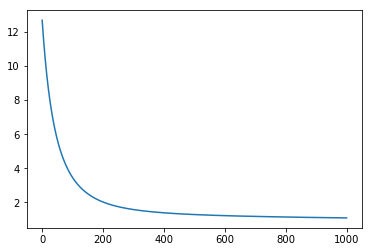

In [108]:
plt.plot(losses)

### 3) Can switch to higher level layers too

In [109]:
# reset the graph
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(N, D), name = 'input')
y = tf.placeholder(tf.float32, shape=(N, 1), name = 'target')

# weights initializer
init = tf.contrib.layers.xavier_initializer()

# hidden layer
h = tf.layers.dense(inputs=x, units=H, 
                    activation=tf.nn.relu, 
                    kernel_initializer = init, 
                    name='hidden_layer')

# output layer
y_pred = tf.layers.dense(inputs=h, units=1, 
                        kernel_initializer = init, 
                        name='output_layer')

# loss
loss = tf.losses.mean_squared_error(y_pred, y)

# updates
optimizer = tf.train.GradientDescentOptimizer(1e-3)
updates = optimizer.minimize(loss)


In [110]:
data = {x: data_x, 
        y: data_y}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    for t in range(1000):
        loss_val, _  = sess.run([loss, updates], 
                                feed_dict = data)
        losses.append(loss_val)


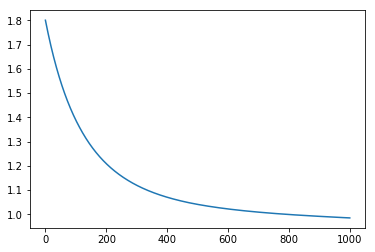

In [111]:
plt.plot(losses)

### 4) Save and test your model

### Train and save - save all the weights of our graph!

In [117]:
saver = tf.train.Saver()

data = {x: data_x, 
        y: data_y}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    for t in range(1000):
        loss_val, _  = sess.run([loss, updates], 
                                feed_dict = data)
        losses.append(loss_val)
        
    saved_path = saver.save(sess, '/home/weimin/workshop/testing.ckpt')
print("Final loss is: {} and model saved at: {}".format(losses[-1], saved_path))

Final loss is: 0.9703320264816284 and model saved at: /home/weimin/workshop/testing.ckpt


### Test it!

In [118]:
# First, we have to rebuild the graph
# reset the graph
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(N, D), name = 'input')
y = tf.placeholder(tf.float32, shape=(N, 1), name = 'target')

# weights initializer
init = tf.contrib.layers.xavier_initializer()

# hidden layer
h = tf.layers.dense(inputs=x, units=H, 
                    activation=tf.nn.relu, 
                    kernel_initializer = init, 
                    name='hidden_layer')

# output layer
y_pred = tf.layers.dense(inputs=h, units=1, 
                        kernel_initializer = init, 
                        name='output_layer')

# loss
loss = tf.losses.mean_squared_error(y_pred, y)

saver = tf.train.Saver()


# Second, load the weights from your previously trained model, and test on your data
data = {x: data_x, 
        y: data_y}

with tf.Session() as sess:

    # Restore model weights from previously saved model
    saver.restore(sess, saved_path)
    
    final_loss = sess.run(loss, feed_dict = data)
print(final_loss)

INFO:tensorflow:Restoring parameters from /home/weimin/workshop/testing.ckpt
0.97033


## Create a convolutional layer

- https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

### 1) The hard way

In [125]:
# input image shape is [batch_size, height, width, channels]
input_image = tf.placeholder(tf.float32, [None, 32, 32, 3])

def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def weight_variable(shape, name = None):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name = name)

def bias_variable(shape, name = None):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)

W_conv = weight_variable([5, 5, 3, 64], name = 'W') # [filter_height, filter_width, in_channels, out_channels]
b_conv = bias_variable([64], name = 'b')
h_conv = tf.nn.relu(conv2d(input_image, W_conv) + b_conv)

In [126]:
h_conv

<tf.Tensor 'Relu_1:0' shape=(?, 32, 32, 64) dtype=float32>

### 2) The easy way

In [127]:
tf.reset_default_graph()

In [128]:
# input image shape is [batch_size, height, width, channels]
input_image = tf.placeholder(tf.float32, [None, 32, 32, 3])

h_conv = tf.layers.conv2d(
  inputs=input_image,
  filters=64,
  kernel_size=[5, 5],
  padding="same",
  kernel_initializer=tf.truncated_normal_initializer,
  activation=tf.nn.relu)

In [131]:
h_conv

<tf.Tensor 'conv2d/Relu:0' shape=(?, 32, 32, 64) dtype=float32>

In [130]:
tf.trainable_variables()

[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32_ref>]

### 3) Pooling layer

In [138]:
h_pool1 = tf.nn.max_pool(h_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [139]:
h_pool1

<tf.Tensor 'MaxPool_3:0' shape=(?, 8, 8, 64) dtype=float32>

### 4) Add an additional convolutional layer

### 5) Flatten last pooling 1-D vector

### 6) FC layer 

### 7) Loss function

### 8) Training Step 

### 9) Prediction and accuracy 

### 10) Train and save the model

### 11) Model evaluation 

### 12) The whole scripts